In [1]:
import pyedflib
import os
import shutil
import glob
import datetime
import time
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

from numpy import mean, sqrt, square, arange
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Read raw PPG files
path = r'prof_data\resteaze\00000192-resteaze-sync.csv'
mdf = pd.read_csv(path, sep=',')
mdf.head()

,Unnamed: 0,counter,unixTimes,accelerometerX,accelerometerY,accelerometerZ,capacitorsA,capacitorsB,capacitorsC,gyroscopeX,...,sleep_state,Leg Movement,Hypopnea,Arousal,RERA,Relative Desaturation,Obstructive Apnea,Central Apnea,Leg Movement (L),Leg Movement (R)
0,2568,2569,1645771253032,1353.0,-472.0,-3934.0,30734.0,NaN,NaN,-149.0,...,-1.0,0,0,0,0,0,0,0,0,0
1,2569,2574,1645771253039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,0,0,0,0,0,0,0,0,0
2,2570,2570,1645771253072,1346.0,-486.0,-3924.0,30733.0,NaN,NaN,-142.0,...,-1.0,0,0,0,0,0,0,0,0,0
3,2571,2575,1645771253079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,0,0,0,0,0,0,0,0,0
4,2572,2571,1645771253112,1342.0,-471.0,-3923.0,30733.0,NaN,NaN,-171.0,...,-1.0,0,0,0,0,0,0,0,0,0


In [3]:
fname = path.split('\\')[-1].split('-')[0]

# TODO: Try to get all the data in one row

In [4]:
# TODO: Add combined epoch data to the dataframe

In [5]:
df = mdf[mdf.sleep_state != -1].reset_index()

df = df[[
    'ledGreen',
    'sleep_state'
]].dropna()
# df['sleep_state'] = df['sleep_state'].mask(lambda col: col == -1, 6)

# Applying the condition
df["sleep_state"] = np.where(df["sleep_state"] == 0, 0, 1)
df.head()

,ledGreen,sleep_state
1,7259.0,0
3,7262.0,0
4,7262.0,0
7,7263.0,0
9,7265.0,0


In [6]:
df['sleep_state'].value_counts()

0    160167
1    107288
Name: sleep_state, dtype: int64

In [7]:
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

# apply bandpass filter

fs = 25
lowcut = 0.65
highcut = 3.0

df['ledGreen'] = butter_bandpass_filter(df['ledGreen'], lowcut, highcut, fs, order=4)

In [8]:
# plt.plot(df['ledGreen'][800:1024], label='Acc signal (%g Hz)' % 25)
# plt.xlabel('time (ms)')
# plt.grid(True)
# plt.axis('tight')
# plt.legend(loc='upper left')

# plt.show()

# plt.plot(df['ledGreen'][800:1024], label='Bandpass signal (%g Hz)' % 25)
# plt.xlabel('time (ms)')
# plt.grid(True)
# plt.axis('tight')
# plt.legend(loc='upper left')

# plt.show()


# Get the analysis for epochs

bpm: 67.796610
ibi: 885.000000
sdnn: 167.854103
sdsd: 99.777530
rmssd: 211.660105
pnn20: 0.833333
pnn50: 0.833333
hr_mad: 100.000000
sd1: 123.288280
sd2: 141.106737
s: 54653.680624
sd1/sd2: 0.873724
breathingrate: 0.282486


C:\Users\lucki\AppData\Local\Temp\ipykernel_25296\4028953298.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  wd, m = hp.process(np.array(df['ledGreen'][1800:2100]), sample_rate=25.0)
c:\Users\lucki\anaconda3\envs\tf\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 2500x400 with 0 Axes>

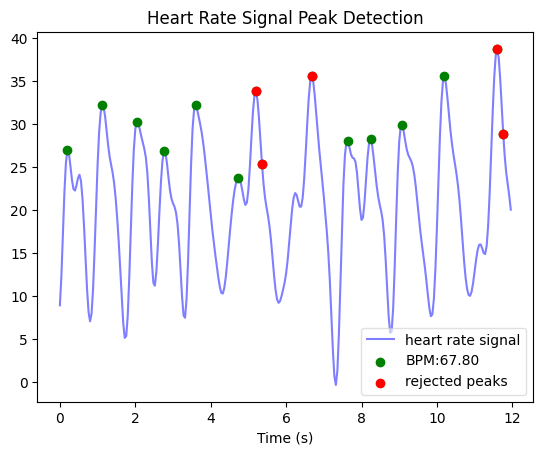

In [9]:
import heartpy as hp

#run the analysis
wd, m = hp.process(np.array(df['ledGreen'][1800:2100]), sample_rate=25.0)

#set large figure
plt.figure(figsize=(25,4))

#call plotter
hp.plotter(wd, m)

#display measures computed
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

In [32]:
#run the segmented analysis
seg_wd, seg_m = hp.process_segmentwise(np.array(df['ledGreen']), sample_rate=25.0, segment_width = 30, )


KeyboardInterrupt: 

<Figure size 2500x600 with 0 Axes>

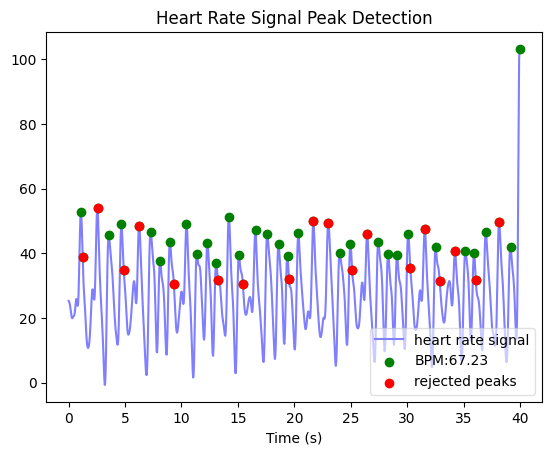

In [31]:
hp.segment_plotter(seg_wd, seg_m, title='Heart Rate Signal Peak Detection', figsize=(25, 6), path='heartpy_outputs/{}'.format(fname), start=0, end=None, step=1)

#### Number of accepted and rejected peaks

In [12]:
wd.keys()

dict_keys(['hr', 'sample_rate', 'peaklist', 'ybeat', 'rolling_mean', 'RR_list', 'RR_indices', 'RR_diff', 'RR_sqdiff', 'rrsd', 'best', 'removed_beats', 'removed_beats_y', 'binary_peaklist', 'RR_masklist', 'RR_list_cor', 'nn20', 'nn50', 'poincare', 'breathing_signal', 'breathing_psd', 'breathing_frq'])

In [13]:
# Rejected peaks
rejectedpeaks = wd['removed_beats']

(rejectedpeaks).shape

(5,)

In [14]:
# Accepted peaks
peaklist = wd['peaklist']

(np.asarray(peaklist)).shape

(15,)

### Update df with the analysis for epochs

In [15]:
wd['hr'].shape

(300,)

In [16]:
df['ledGreen'].shape

(267455,)

In [33]:
seg_wd.keys(), seg_m.keys()

(dict_keys(['hr', 'sample_rate', 'peaklist', 'ybeat', 'rolling_mean', 'RR_list', 'RR_indices', 'RR_diff', 'RR_sqdiff', 'rrsd', 'best', 'removed_beats', 'removed_beats_y', 'binary_peaklist', 'RR_masklist', 'RR_list_cor', 'nn20', 'nn50', 'poincare', 'breathing_signal', 'breathing_psd', 'breathing_frq', 'segment_indices']),
 dict_keys(['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate', 'segment_indices']))

In [34]:
len(seg_m['bpm'])

355

In [41]:
len(seg_wd['RR_list'])

355

In [66]:
len(seg_wd['hr'])

355